In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk.internals
from gensim import corpora, models


from numpy import dot
from numpy.linalg import norm

from collections import defaultdict


/Users/rousselpaul/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# I - Initialisation de données# 

In [2]:


questions = {}
pairs_train = []
y_train = []
with open('train.csv','r',encoding='utf8') as f:
    for line in f:
        l = line.split(',')
        if l[1] not in questions:
            questions[l[1]] = l[3]
        if l[2] not in questions:
            questions[l[2]] = l[4]

        pairs_train.append([l[1], l[2]])
        y_train.append(int(l[5][:-1]))

pairs_test = []
with open('test.csv','r',encoding='utf8') as f:
    for line in f:
        l = line.split(',')
        if l[1] not in questions:
            questions[l[1]] = l[3]
        if l[2] not in questions:
            questions[l[2]] = l[4][:-1]

        pairs_test.append([l[1], l[2]])


ids2ind = {}
for qid in questions:
    ids2ind[qid] = len(ids2ind) 

vec = TfidfVectorizer()
A = vec.fit_transform(questions.values())


pairs_train_everything = pairs_train
pairs_test_submission = pairs_test

corpus = [questions[k] for k in questions]






Découpage des données

In [3]:
Pourcentage_test = 0.05
pairs_split_train, pairs_split_test = train_test_split(np.c_[ np.array(pairs_train), np.array(y_train) ], test_size=Pourcentage_test, random_state=42)

print(pairs_split_train.shape)
print(pairs_split_test.shape)

(76095, 3)
(4005, 3)


In [4]:
pairs_split_train

array([['264621', '285217', '1'],
       ['37774', '331401', '1'],
       ['199268', '44306', '1'],
       ...,
       ['190489', '324591', '0'],
       ['274647', '345606', '0'],
       ['266795', '261371', '1']], dtype='<U21')

In [93]:
pairs_train = pairs_split_train[:,0:2]
y_train = pairs_split_train[:,2]
pairs_test = pairs_split_test[:,0:2]
y_test = pairs_split_test[:,2]

In [5]:
pairs_train

[['199954', '384085'],
 ['128681', '237407'],
 ['170846', '240621'],
 ['55110', '177468'],
 ['425513', '400256'],
 ['105990', '256943'],
 ['366314', '224793'],
 ['167249', '167582'],
 ['344939', '281696'],
 ['107721', '138968'],
 ['70380', '189775'],
 ['422283', '387926'],
 ['353154', '165955'],
 ['116890', '223712'],
 ['56193', '284398'],
 ['192860', '103497'],
 ['419061', '401379'],
 ['365562', '261605'],
 ['407441', '232114'],
 ['26559', '148265'],
 ['17731', '345422'],
 ['365785', '246499'],
 ['253071', '379651'],
 ['191369', '110891'],
 ['415414', '208199'],
 ['284484', '407521'],
 ['216343', '420785'],
 ['167736', '124268'],
 ['419030', '355200'],
 ['48073', '311559'],
 ['439901', '409602'],
 ['191427', '178840'],
 ['92533', '140695'],
 ['371314', '442265'],
 ['79616', '41245'],
 ['22415', '7769'],
 ['232757', '329622'],
 ['447323', '426653'],
 ['150300', '102863'],
 ['352998', '60737'],
 ['274167', '239269'],
 ['20081', '186848'],
 ['206218', '381587'],
 ['78910', '83625'],
 ['1

In [202]:
train_orig = pd.DataFrame({'id':[j for j in range(len(pairs_train))],'qid1':pairs_train[:,0],'qid2':pairs_train[:,1],'question1':[questions[x] for x in pairs_train[:,0]],'question2':[questions[x] for x in pairs_train[:,1]],'is_duplicate':y_train})
test_orig = pd.DataFrame({'id':[j for j in range(len(pairs_test))],'qid1':pairs_test[:,0],'qid2':pairs_test[:,1],'question1':[questions[x] for x in pairs_test[:,0]],'question2':[questions[x] for x in pairs_test[:,1]]})



# cleaning

https://www.kaggle.com/currie32/the-importance-of-cleaning-text
https://towardsdatascience.com/finding-similar-quora-questions-with-bow-tfidf-and-random-forest-c54ad88d1370

In [8]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text
    
#df['question1'] = df['question1'].apply(clean)
#df['question2'] = df['question2'].apply(clean)

questions_cleaned = {}
for qid in questions:
    questions_cleaned[qid] = clean(questions[qid])
    
 
vec_cleaned = TfidfVectorizer()
A_cleaned = vec_cleaned.fit_transform(questions_cleaned.values())

In [ ]:
number_colums = len(X_train[0])

# Fonction cadre

function doit renvoyer X_train et X_test comme features
nom_fichier doit être de la forme 'page_rank'


In [6]:


def creat_features(function,nom_fichier):
    X_train,X_test = function()
    number_colums = len(X_train[0])
    N_train = len(pairs_train)
    N_test = len(pairs_test)
    
    nom_features = ''
    for j in range(number_colums):        
        if j == (number_colums-1):
            nom_features = nom_features +'f'+ str(j+1)
        else:
            nom_features = nom_features +'f'+ str(j+1)+','
        
        
    nom_fichier_train = nom_fichier +'_' +str(N_train) +'_train.csv'
    with open(nom_fichier_train, 'w') as f: 
        f.write(nom_features+ '\n')
        for i in range(len(pairs_train)):
            for j in range(number_colums):
                if j == (number_colums-1):
                    f.write(str(X_train[i,j]))
                else:
                    f.write(str(X_train[i,j])+',')
            f.write('\n')
        
    nom_fichier_test = nom_fichier  +'_' +str(N_train) +'_test.csv'   
    with open(nom_fichier_test, 'w') as f:
        f.write(nom_features+ '\n')
        for i in range(len(pairs_test)):
            for j in range(number_colums):
                if j == (number_colums-1):
                    f.write(str(X_test[i,j]))
                else:
                    f.write(str(X_test[i,j])+',')
            f.write('\n')
    open('names_of_features', 'a+').write(nom_fichier_train+',' + nom_fichier_test+'\n')

In [51]:
creat_features(features_teacher,'features_teacher')

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

In [7]:
def load_features(nom_fichier):
    
    with open(nom_fichier,'r',encoding='utf8') as f:
        first = True
        for line in f:
            l = line.rstrip().split(',')
            
            if first:
                X = []
                first = False
            else:
                vect = [float(x) for x in l]
                X.append(vect)
        return(np.array(X))

In [61]:
load_features('features_teacher_76095_train.csv')

array([[ 0.46985791, 14.        ,  2.        ],
       [ 0.73824329, 25.        ,  1.        ],
       [ 0.54415074, 18.        ,  4.        ],
       ...,
       [ 0.8582973 , 30.        ,  0.        ],
       [ 0.23492271, 16.        ,  2.        ],
       [ 0.4260053 , 16.        ,  0.        ]])

In [62]:
def load_all_features():
    with open('names_of_features','r',encoding='utf8') as f:
        first = True
        for line in f:
            l = line.rstrip().split(',')
            if first:
                first = False
                X_train = load_features(l[0])
                X_test = load_features(l[1])
            else:
                X_train = np.c_[ X_train, load_features(l[0]) ]
                X_test = np.c_[ X_test, load_features(l[1]) ]
    return(X_train,X_test)

In [63]:
X_train,X_test = load_all_features()

# Features

# Features du prof

In [1]:
def features_teacher():
    N_train = len(pairs_train)
    X_train = np.zeros((N_train, 3))

    counter = 0
    for i in range(len(pairs_train)):
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        X_train[i,0] = cosine_similarity(A_cleaned[ids2ind[q1],:], A_cleaned[ids2ind[q2],:])
        X_train[i,1] = len(questions_cleaned[q1].split()) + len(questions_cleaned[q2].split())
        X_train[i,2] = abs(len(questions_cleaned[q1].split()) - len(questions_cleaned[q2].split()))
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")

    N_test = len(pairs_test)
    X_test = np.zeros((N_test, 3))

    counter = 0
    for i in range(len(pairs_test)):
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]
        X_test[i,0] = cosine_similarity(A_cleaned[ids2ind[q1],:], A_cleaned[ids2ind[q2],:])
        X_test[i,1] = len(questions_cleaned[q1].split()) + len(questions_cleaned[q2].split())
        X_test[i,2] = abs(len(questions_cleaned[q1].split()) - len(questions_cleaned[q2].split()))
        counter += 1
        if counter % 1000 == True:
            print (counter, "testing examples processsed")
    return(X_train,X_test)

# features doc2vec

In [72]:
def features_doc2vec():
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]

    max_epochs = 2
    vec_size = 100
    alpha = 0.025

    modeldoc = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =1)

    modeldoc.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        modeldoc.train(tagged_data,
                    total_examples=modeldoc.corpus_count,
                    epochs=modeldoc.iter)
        # decrease the learning rate
        modeldoc.alpha -= 0.0002
        # fix the learning rate, no decay
        modeldoc.min_alpha = modeldoc.alpha


    doc2vec_train1 = []
    doc2vec_train2 = []
    counter = 0
    for i in range(len(pairs_train)):
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        doc2vec_train1.append(modeldoc.infer_vector(questions[q1]))
        doc2vec_train2.append(modeldoc.infer_vector(questions[q2]))
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")

    doc2vec_test1 = []
    doc2vec_test2 = []
    counter = 0
    for i in range(len(pairs_test)):
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]
        doc2vec_test1.append(modeldoc.infer_vector(questions[q1]))
        doc2vec_test2.append(modeldoc.infer_vector(questions[q2]))
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")


    X_train = np.c_[ np.array(doc2vec_train1),np.array(doc2vec_train2) ]
    X_test = np.c_[np.array(doc2vec_test1),np.array(doc2vec_test2) ]
    return(X_train,X_test)

In [73]:
creat_features(features_doc2vec,'features_doc2vec')

iteration 0
iteration 1
1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 tra

In [74]:
X_train,X_test = load_all_features()

# features word2vec - non fini

In [216]:
import gensim
 
    
def word2vec_pretrained_sim_features():
    # Load Google's pre-trained Word2Vec model.
    model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

    def filter(tokens):
        tokens_filtered = []
        for x in tokens:
            if x in model.vocab:
                tokens_filtered.append(x)
        if not tokens_filtered:
            return(['empty'])
        return(tokens_filtered)

    text_sim_training = []
    counter = 0
    for i in range(len(pairs_train)): 
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        text_sim_training.append([model.n_similarity(filter(questions_cleaned[q1].split()),filter(questions_cleaned[q2].split()))])
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")
    #text_sim_training

    text_sim_testing = []
    counter = 0
    for i in range(len(pairs_test)): 
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]
        text_sim_testing.append([model.n_similarity(filter(questions_cleaned[q1].split()),filter(questions_cleaned[q2].split()))])

        if counter % 1000 == True:
            print (counter, "testing examples processsed")
    #text_sim_testing

    return(np.array(text_sim_training),np.array(text_sim_testing))

In [217]:
creat_features(word2vec_pretrained_sim_features,'word2vec_pretrained_sim_features')

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

In [219]:
def word2vec_pretrained_features():
    # Load Google's pre-trained Word2Vec model.
    model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

    def filter(tokens):
        tokens_filtered = []
        for x in tokens:
            if x in model.vocab:
                tokens_filtered.append(x)
        if not tokens_filtered:
            return(['empty'])
        return(tokens_filtered)
    
    word2vec_train1 = []
    word2vec_train2 = []
    counter = 0
    for i in range(len(pairs_train)):
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        word2vec_train1.append(model.infer_vector(filter(questions_cleaned[q1].split())))
        word2vec_train2.append(model.infer_vector(filter(questions_cleaned[q1].split())))
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")

    word2vec_test1 = []
    word2vec_test2 = []
    counter = 0
    for i in range(len(pairs_test)):
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]
        word2vec_test1.append(model.infer_vector(filter(questions_cleaned[q1].split())))
        word2vec_test2.append(model.infer_vector(filter(questions_cleaned[q1].split())))
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")


    X_train = np.c_[ np.array(word2vec_train1),np.array(word2vec_train2) ]
    X_test = np.c_[np.array(word2vec_test1),np.array(word2vec_test2) ]
    return(X_train,X_test)

In [221]:
X_train,X_test = word2vec_pretrained_features()

AttributeError: 'EuclideanKeyedVectors' object has no attribute 'infer_vector'

In [213]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate([questions_cleaned[k] for k in questions_cleaned])]

max_epochs = 20
vec_size = 100
alpha = 0.025

  
modeldoc.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    modeldoc.train(tagged_data,
                total_examples=modeldoc.corpus_count,
                epochs=modeldoc.iter)
    # decrease the learning rate
    modeldoc.alpha -= 0.0002
    # fix the learning rate, no decay
    modeldoc.min_alpha = modeldoc.alpha

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [145]:
#X_test = np.delete(X_test, [3,4], 1)

# LDA

In [82]:
def features_LDA():

    corpus_cleaned = [questions_cleaned[k] for k in questions_cleaned]


    list_of_list_of_tokens =[]
    for i in range(len(list(questions_cleaned.values()))):
        text=corpus_cleaned[i].lower()
        nltk_tokens = nltk.word_tokenize(text)
        stemmed_tokens=[]
        for w in nltk_tokens:
            if (len(w)>3):
                lemmatized_token=wordnet_lemmatizer.lemmatize(w)
                stemmed_tokens.append(porter_stemmer.stem(lemmatized_token))
        list_of_list_of_tokens.append(stemmed_tokens)

    dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
    dictionary_LDA.filter_extremes(no_below=3)
    corpusLDA = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

    num_topics = 20
    lda_model = models.LdaModel(corpusLDA, num_topics=num_topics, 
                                      id2word=dictionary_LDA, 
                                      passes=4, alpha=[0.01]*num_topics,
                                      eta=[0.01]*len(dictionary_LDA.keys()))
    for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
        print(str(i)+": "+ topic)
        print()

    counter=0
    lda_similarity_training=[]
    for i in range (len(pairs_train)):
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        all_topics_source=[0]*num_topics
        all_topics_target=[0]*num_topics
        topics_source= lda_model[corpusLDA[ids2ind[q1]]]
        topics_target=lda_model[corpusLDA[ids2ind[q2]]]
        for k in topics_source:
            all_topics_source[k[0]]=k[1]
        for k in topics_target:
            all_topics_target[k[0]]=k[1]
        cos_sim = dot(all_topics_source, all_topics_target)/(norm(all_topics_source)*norm(all_topics_target))
        lda_similarity_training.append([cos_sim])

        counter += 1
        if counter % 1000 == True:
            print(counter, "training examples processsed")
    counter=0
    lda_similarity_testing=[]
    for i in range (len(pairs_test)):
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]

        all_topics_source=[0]*num_topics
        all_topics_target=[0]*num_topics
        topics_source= lda_model[corpusLDA[ids2ind[q1]]]
        topics_target=lda_model[corpusLDA[ids2ind[q2]]]
        for k in topics_source:
            all_topics_source[k[0]]=k[1]
        for k in topics_target:
            all_topics_target[k[0]]=k[1]
        cos_sim = dot(all_topics_source, all_topics_target)/(norm(all_topics_source)*norm(all_topics_target))
        lda_similarity_testing.append([cos_sim])

        counter += 1
        if counter % 1000 == True:
            print(counter, "testing examples processsed")
    
    return(np.array(lda_similarity_training),np.array(lda_similarity_testing))

In [83]:
creat_features(features_LDA,'features_LDA')

/Users/rousselpaul/anaconda/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


0: 0.184*"what" + 0.182*"best" + 0.087*"learn" + 0.057*"book" + 0.040*"which" + 0.033*"program" + 0.026*"languag" + 0.025*"2016" + 0.024*"countri" + 0.021*"comput"

1: 0.152*"what" + 0.097*"differ" + 0.083*"life" + 0.077*"between" + 0.038*"websit" + 0.033*"song" + 0.030*"live" + 0.023*"your" + 0.022*"real" + 0.021*"human"

2: 0.075*"realli" + 0.048*"could" + 0.045*"were" + 0.042*"note" + 0.039*"help" + 0.036*"black" + 0.032*"what" + 0.032*"true" + 0.030*"govern" + 0.024*"1000"

3: 0.049*"improv" + 0.045*"studi" + 0.041*"follow" + 0.040*"need" + 0.037*"english" + 0.037*"colleg" + 0.036*"mobil" + 0.035*"play" + 0.033*"just" + 0.032*"write"

4: 0.177*"what" + 0.124*"some" + 0.071*"make" + 0.065*"good" + 0.047*"time" + 0.042*"money" + 0.041*"best" + 0.029*"onlin" + 0.026*"way" + 0.024*"that"

5: 0.195*"with" + 0.061*"love" + 0.057*"person" + 0.052*"without" + 0.035*"what" + 0.035*"world" + 0.032*"busi" + 0.024*"onli" + 0.021*"idea" + 0.019*"hair"

6: 0.114*"phone" + 0.062*"number" + 0.061*

In [84]:
X_train,X_test = load_all_features()

(76095, 204)

# LSA sim

In [8]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity

In [ ]:
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [17]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

In [222]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]

In [19]:
[d.split() for d in corpus]

[['"What', 'are', 'the', 'some', 'of', 'the', 'best', 'novels?"'],
 ['"What',
  'are',
  'some',
  'of',
  'the',
  'greatest',
  'novels',
  'of',
  'all',
  'time?',
  'Why',
  'are',
  'they',
  'great?"'],
 ['"What', 'are', 'the', 'pictures', 'that', 'made', 'you', 'look', 'twice?"'],
 ['"What',
  'are',
  'some',
  'amazing',
  'pictures',
  'one',
  'has',
  'to',
  'see',
  'twice',
  'to',
  'understand?"'],
 ['"Have',
  'the',
  'ellectoral',
  'college',
  'members',
  'ever',
  'voted',
  'differently',
  'then',
  'the',
  'popular',
  'vote',
  'suggested',
  'they',
  'should',
  'vote?"'],
 ['"When',
  'has',
  'the',
  'electoral',
  'college',
  'voted',
  'against',
  'the',
  'popular',
  'vote?"'],
 ['"Did', 'Ravana', 'really', 'have', '10', 'heads?"'],
 ['"Why', 'did', 'Ravana', 'have', '10', 'heads?"'],
 ['"What\'s',
  'a',
  'book',
  'that',
  'you',
  'feel',
  'helped',
  'you',
  'to',
  'improve',
  'intellectually?"'],
 ['"What',
  'books',
  'or',
  'magaz

In [34]:
from sklearn.metrics.pairwise import cosine_similarity




array([[1.]])

In [233]:
# LSA Model
number_of_topics=7
words=10
#document_list,titles=load_data("","articles.txt")
prepare_text=prepare_corpus(corpus)
#model=create_gensim_lsa_model(clean_text,number_of_topics,words)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [24]:
dictionary = corpora.Dictionary([d.split() for d in corpus])
corpus_gensim = [dictionary.doc2bow(doc.split()) for doc in corpus]   
tfidf = TfidfModel(corpus_gensim)
corpus_tfidf = tfidf[corpus_gensim]
lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)


In [26]:
vec_bow = dictionary.doc2bow(corpus[0].lower().split())   
vec_lsi = lsi[vec_bow]
[x[1] for x in vec_lsi]

In [30]:
[x[1] for x in vec_lsi]

[1.155680427536988,
 1.3062715770448448,
 0.10709776703347901,
 -0.4335887472481544,
 0.5855573046178008]

In [22]:
coherence_values = []
model_list = []
start,stop,step=2,30,1
for num_topics in range(start, stop, step):
    # generate LSA model
    print(num_topics)
    model = LsiModel(corpus_tfidf, num_topics=num_topics, id2word = dictionary)  # train model
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=[d.split() for d in corpus], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [15]:
dictionary

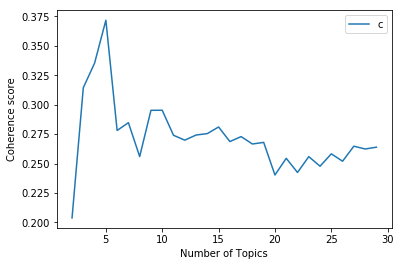

In [23]:
#dictionary,doc_term_matrix=prepare_corpus(doc_clean)
#model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,stop, start, step)
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
def LSA_features():
    dictionary = corpora.Dictionary([d.split() for d in corpus])
    corpus_gensim = [dictionary.doc2bow(doc.split()) for doc in corpus]   
    tfidf = TfidfModel(corpus_gensim)
    corpus_tfidf = tfidf[corpus_gensim]
    lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)
    
    
    
    counter=0
    lsa_similarity_training=[]
    for i in range (len(pairs_train)):
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]

        vec_bow1 = dictionary.doc2bow(questions[q1].lower().split())   
        vec_lsi1 = lsi[vec_bow1]
        vec_bow2 = dictionary.doc2bow(questions[q2].lower().split())   
        vec_lsi2 = lsi[vec_bow2]
        
        if not [x[1] for x in vec_lsi1] or not [x[1] for x in vec_lsi2]:
            cos_sim = 0
        else: 
            cos_sim = cosine_similarity([[x[1] for x in vec_lsi1]],[[x[1] for x in vec_lsi2]])
        lsa_similarity_training.append([cos_sim])
        counter += 1
        if counter % 1000 == True:
            print(counter, "training examples processsed")
            
            
            
    counter=0
    lsa_similarity_testing=[]
    for i in range (len(pairs_test)):
        q1 = pairs_test[i][0]
        q2 = pairs_test[i][1]
        
        vec_bow1 = dictionary.doc2bow(questions[q1].lower().split())   
        vec_lsi1 = lsi[vec_bow1]
        vec_bow2 = dictionary.doc2bow(questions[q2].lower().split())   
        vec_lsi2 = lsi[vec_bow2]
        if not [x[1] for x in vec_lsi1] or not [x[1] for x in vec_lsi2]:
            cos_sim = 0
        else: 
            cos_sim = cosine_similarity([[x[1] for x in vec_lsi1]],[[x[1] for x in vec_lsi2]])
        lsa_similarity_testing.append([cos_sim])
        counter += 1
        if counter % 1000 == True:
            print(counter, "testing examples processsed")
    
    return(np.array(lsa_similarity_training),np.array(lsa_similarity_testing))

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

(array([[array([[0.91524612]])],
        [array([[0.65974795]])],
        [array([[0.93475091]])],
        ...,
        [array([[0.99450931]])],
        [array([[0.9610865]])],
        [array([[0.96134636]])]], dtype=object),
 array([[array([[0.93314743]])],
        [array([[0.99957739]])],
        [array([[0.98480479]])],
        ...,
        [array([[0.97308892]])],
        [array([[0.84378918]])],
        [array([[0.95149506]])]], dtype=object))

In [39]:
not []

True

# Glove 

In [ ]:
#importing the glove library
from glove import Corpus, Glove
# creating a corpus object
corpus = Corpus() 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(lines, window=10)
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=5, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

glove.add_dictionary(corpus.dictionary)

# magic trick

In [113]:
import numpy as np
import pandas as pd
import timeit

In [106]:
train_orig =  pd.DataFrame({'question1':pairs_train[:,0],'question2':pairs_train[:,1]})
test_orig =  pd.DataFrame({'question1':pairs_test[:,0],'question2':pairs_test[:,1]})

In [107]:
ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(80100, 2)

In [108]:
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [126]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [127]:
train_orig.apply(q1_q2_intersect, axis=1, raw=True)
test_orig.apply(q1_q2_intersect, axis=1, raw=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
train_orig =  pd.read_csv('train2.csv', header=0)
test_orig =  pd.read_csv('test2.csv', header=0)

In [187]:
train_orig

,id,qid1,qid2,question1,question2,is_duplicate,q1_q2_intersect
0,0,264621,285217,"""What is your New Year Resolution?""","""What Is your New year resolutions in 2017?""",1,10
1,1,37774,331401,"""What are some alternatives ways to lose 30 po...","""How can I lose 30 pounds in 1 month? What are...",1,5
2,2,199268,44306,"""Which is the best programming language for a ...","""What programming language I should learn first?""",1,8
3,3,315658,291313,"""How do I get VoLTE symbol in Redmi Note 3?""","""Does Coolpad Note 3 supports VoLTE?""",0,0
4,4,70704,328389,"""Why do we have nightmares? What is the cause ...","""Why do we get Nightmares?""",1,2
5,5,211481,53379,"""When will Apple release the new MacBook Pro i...","""When is the new Apple Macbook Pro coming? In ...",1,9
6,6,21222,38260,"""Is it healthy to eat chapati every day?""","""Is it healthy to eat one chicken every day?""",0,3
7,7,330104,331067,"""What is the difference between applications (...","""What is the difference between an app and a s...",1,3
8,8,9872,325409,"""What are the best movie scenes ever? What mak...","""What are the best scenes in movie history?""",1,0
9,9,404109,104740,"""Will Donald Trump’s win in the elections have...","""How would Trump presidency affect Indian stud...",1,2


In [174]:
def magic_trick1():

    tic0=timeit.default_timer()
    df1 = train_orig[['question1']].copy()
    df2 = train_orig[['question2']].copy()
    df1_test = test_orig[['question1']].copy()
    df2_test = test_orig[['question2']].copy()

    df2.rename(columns = {'question2':'question1'},inplace=True)
    df2_test.rename(columns = {'question2':'question1'},inplace=True)

    train_questions = df1.append(df2)
    train_questions = train_questions.append(df1_test)
    train_questions = train_questions.append(df2_test)
    #train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
    train_questions.drop_duplicates(subset = ['question1'],inplace=True)

    train_questions.reset_index(inplace=True,drop=True)
    questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
    train_cp = train_orig.copy()
    test_cp = test_orig.copy()
    train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

    test_cp['is_duplicate'] = -1
    test_cp.rename(columns={'test_id':'id'},inplace=True)
    comb = pd.concat([train_cp,test_cp])

    comb['q1_hash'] = comb['question1'].map(questions_dict)
    comb['q2_hash'] = comb['question2'].map(questions_dict)

    q1_vc = comb.q1_hash.value_counts().to_dict()
    q2_vc = comb.q2_hash.value_counts().to_dict()

    def try_apply_dict(x,dict_to_apply):
        try:
            return dict_to_apply[x]
        except KeyError:
            return 0
    #map to frequency space
    comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

    train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
    test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

    return(train_comb[['id','q1_hash','q2_hash','q1_freq','q2_freq']].values,test_comb[['id','q1_hash','q2_hash','q1_freq','q2_freq']].values)

In [175]:
creat_features(magic_trick1,'magic_trick1')

/Users/rousselpaul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [168]:
def magic_trick2():

    ques = pd.concat([train_orig[['question1', 'question2']], \
            test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
    ques.shape

    q_dict = defaultdict(set)
    for i in range(ques.shape[0]):
            q_dict[ques.question1[i]].add(ques.question2[i])
            q_dict[ques.question2[i]].add(ques.question1[i])

    def q1_q2_intersect(row):
        return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

    train_orig['q1_q2_intersect'] = train_orig.apply(q1_q2_intersect, axis=1, raw=True)
    test_orig['q1_q2_intersect'] = test_orig.apply(q1_q2_intersect, axis=1, raw=True)

    temp = train_orig.q1_q2_intersect.value_counts()
    #sns.barplot(temp.index[:20], temp.values[:20])

    train_feat = train_orig[['q1_q2_intersect']]
    test_feat = test_orig[['q1_q2_intersect']]
    return(train_feat.values,test_feat.values)

In [176]:
creat_features(magic_trick2,'magic_trick2')

features https://github.com/aerdem4/kaggle-quora-dup/blob/master/nlp_feature_extraction.py

In [184]:
import re
import pandas as pd
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import distance

In [189]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x


def get_token_features(q1, q2):
    token_features = [0.0]*10

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    print("fuzzy features..")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [192]:
def extract_NLP_features():
    train_df = extract_features(train_orig)
    train_df.drop(["id", "qid1", "qid2", "question1", "question2", "is_duplicate"], axis=1, inplace=True)
    
    test_df = extract_features(test_orig)
    test_df.drop(["id", "qid1", "qid2", "question1", "question2"], axis=1, inplace=True)
    return(train_df.values,test_df.values)

In [193]:
creat_features(extract_NLP_features,'extract_NLP_features')

token features...
fuzzy features..
token features...
fuzzy features..


In [198]:
from collections import defaultdict
import numpy as np
import pandas as pd
import networkx as nx

NB_CORES = 10
FREQ_UPPER_BOUND = 100
NEIGHBOR_UPPER_BOUND = 5


def create_question_hash(train_df, test_df):
    train_qs = np.dstack([train_df["question1"], train_df["question2"]]).flatten()
    test_qs = np.dstack([test_df["question1"], test_df["question2"]]).flatten()
    all_qs = np.append(train_qs, test_qs)
    all_qs = pd.DataFrame(all_qs)[0].drop_duplicates()
    all_qs.reset_index(inplace=True, drop=True)
    question_dict = pd.Series(all_qs.index.values, index=all_qs.values).to_dict()
    return question_dict


def get_hash(df, hash_dict):
    df["qid1"] = df["question1"].map(hash_dict)
    df["qid2"] = df["question2"].map(hash_dict)
    return df.drop(["question1", "question2"], axis=1)


def get_kcore_dict(df):
    g = nx.Graph()
    g.add_nodes_from(df.qid1)
    edges = list(df[["qid1", "qid2"]].to_records(index=False))
    g.add_edges_from(edges)
    g.remove_edges_from(g.selfloop_edges())

    df_output = pd.DataFrame(data=g.nodes(), columns=["qid"])
    df_output["kcore"] = 0
    for k in range(2, NB_CORES + 1):
        ck = nx.k_core(g, k=k).nodes()
        print("kcore", k)
        df_output.ix[df_output.qid.isin(ck), "kcore"] = k

    return df_output.to_dict()["kcore"]


def get_kcore_features(df, kcore_dict):
    df["kcore1"] = df["qid1"].apply(lambda x: kcore_dict[x])
    df["kcore2"] = df["qid2"].apply(lambda x: kcore_dict[x])
    return df


def convert_to_minmax(df, col):
    sorted_features = np.sort(np.vstack([df[col + "1"], df[col + "2"]]).T)
    df["min_" + col] = sorted_features[:, 0]
    df["max_" + col] = sorted_features[:, 1]
    return df.drop([col + "1", col + "2"], axis=1)


def get_neighbors(train_df, test_df):
    neighbors = defaultdict(set)
    for df in [train_df, test_df]:
        for q1, q2 in zip(df["qid1"], df["qid2"]):
            neighbors[q1].add(q2)
            neighbors[q2].add(q1)
    return neighbors


def get_neighbor_features(df, neighbors):
    common_nc = df.apply(lambda x: len(neighbors[x.qid1].intersection(neighbors[x.qid2])), axis=1)
    min_nc = df.apply(lambda x: min(len(neighbors[x.qid1]), len(neighbors[x.qid2])), axis=1)
    df["common_neighbor_ratio"] = common_nc / min_nc
    df["common_neighbor_count"] = common_nc.apply(lambda x: min(x, NEIGHBOR_UPPER_BOUND))
    return df


def get_freq_features(df, frequency_map):
    df["freq1"] = df["qid1"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    df["freq2"] = df["qid2"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    return df

In [208]:
def extract_not_NLP_features():
    train_df = train_orig
    test_df = test_orig

    print("Hashing the questions...")
    question_dict = create_question_hash(train_df, test_df)
    train_df = get_hash(train_df, question_dict)
    test_df = get_hash(test_df, question_dict)
    print("Number of unique questions:", len(question_dict))


    print("Calculating common neighbor features...")
    neighbors = get_neighbors(train_df, test_df)
    train_df = get_neighbor_features(train_df, neighbors)
    test_df = get_neighbor_features(test_df, neighbors)

    print("Calculating frequency features...")
    frequency_map = dict(zip(*np.unique(np.vstack((all_df["qid1"], all_df["qid2"])), return_counts=True)))
    train_df = get_freq_features(train_df, frequency_map)
    test_df = get_freq_features(test_df, frequency_map)
    train_df = convert_to_minmax(train_df, "freq")
    test_df = convert_to_minmax(test_df, "freq")

    cols = [ "common_neighbor_count", "common_neighbor_ratio", "min_freq", "max_freq"]

    return(train_df.loc[:, cols].values,test_df.loc[:, cols].values)

In [209]:
creat_features(extract_not_NLP_features,'extract_not_NLP_features')

Hashing the questions...
Number of unique questions: 51856
Calculating common neighbor features...
Calculating frequency features...


In [210]:
X_train,X_test = load_all_features()

# syntax 

In [3]:
import nltk
from nltk.corpus import treebank
from nltk import Tree
from nltk import nonterminals, Nonterminal, Production
from nltk.parse import ViterbiParser
S = Nonterminal('S')
grammar = induce_pcfg(S, productions)

NameError: name 'induce_pcfg' is not defined

In [2]:
s= 'I saw John with my eyes'
tokens = s.split() #simplified – you can use a tokenizer 
parser=ViterbiParser(grammar) #using the grammar induced by the Treebank 
parses = parser.parse_all(tokens) #the resulting parse tree

NameError: name 'grammar' is not defined

In [ ]:
getBestParse()

In [6]:
import nltk
from nltk.corpus import treebank
from nltk.grammar import ContextFreeGrammar, Nonterminal

ImportError: cannot import name 'ContextFreeGrammar'

In [5]:
import treebank-grammar as tg
g = tg.extract_simple_pcfg(1000)
import nltk.parse as np
c = np.ChartParser(g)
p = c.parse(’The rates rise .’.split())
len(list(p))       # prints number of parses

SyntaxError: invalid syntax (<ipython-input-5-0ddb0cc0b49b>, line 1)

In [ ]:
p = c.parse(’The rates rise .’.split())
print(p.next())    # prints first parse tree

In [7]:
from textblob import TextBlob


In [8]:
blob = TextBlob("Analytics Vidhya is a great platform to learn data science. \n It helps community through blogs, hackathons, discussions,etc.")

In [11]:
blob.tags

[('Analytics', 'NNS'),
 ('Vidhya', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('great', 'JJ'),
 ('platform', 'NN'),
 ('to', 'TO'),
 ('learn', 'VB'),
 ('data', 'NNS'),
 ('science', 'NN'),
 ('It', 'PRP'),
 ('helps', 'VBZ'),
 ('community', 'NN'),
 ('through', 'IN'),
 ('blogs', 'NNS'),
 ('hackathons', 'NNS'),
 ('discussions', 'NNS'),
 ('etc', 'FW')]

# Modality

In [32]:
import spacy

ModuleNotFoundError: No module named 'spacy'

And/CC/O/O now/RB/B-ADVP/O for/IN/B-PP/B-PNP something/NN/B-NP/I-PNP completely/RB/B-ADJP/O different/JJ/I-ADJP/O ././O/O


SyntaxError: invalid syntax (__init__.py, line 102)

# Prediction

In [97]:
import math
from sklearn.metrics import log_loss

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [94]:

y_train = np.array([int(x) for x in y_train.tolist()])

In [87]:
y_train

array(['1', '1', '1', ..., '0', '0', '1'], dtype='<U21')

In [211]:
clf = RandomForestClassifier(n_estimators=500, max_depth=4, n_jobs=-1,verbose=3)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
print(y_pred)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 2 of 500building tree 3 of 500building tree 1 of 500building tree 4 of 500



building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s


building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500building tree 40 of 500

building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.0s


building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.8s


building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s


[[0.63769125 0.36230875]
 [0.09649006 0.90350994]
 [0.64587736 0.35412264]
 ...
 [0.72428397 0.27571603]
 [0.66371163 0.33628837]
 [0.07613816 0.92386184]]


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


In [212]:
log_loss(np.array([int(x) for x in y_test.tolist()]), y_pred[:,1])

0.2983443718893396

In [197]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=200,verbose=3, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='reg:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict_proba(X_test)
print(xgb_prediction)


KeyboardInterrupt: 

In [ ]:
log_loss(np.array([int(x) for x in y_test.tolist()]), xgb_prediction[:,1])

# deep learning

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.


In [210]:
model = keras.Sequential([
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l2(0.001),activation='linear'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l2(0.001),activation='linear'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2, activation=tf.nn.softmax)
    
])
    
model.compile(optimizer=tf.train.AdamOptimizer(), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


history=model.fit(X_train, np.array(y_train), epochs=30, batch_size=1000, verbose=1)
#predictions
predictions = model.predict(X_test)


Epoch 1/30
56070/56070 [==============================] - 4s 67us/step - loss: 0.8459 - acc: 0.6070
Epoch 2/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7409 - acc: 0.6563
Epoch 3/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7332 - acc: 0.6681
Epoch 4/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7377 - acc: 0.6623
Epoch 5/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7291 - acc: 0.6695
Epoch 6/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7335 - acc: 0.6620
Epoch 7/30
56070/56070 [==============================] - 1s 12us/step - loss: 0.7302 - acc: 0.6649
Epoch 8/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7239 - acc: 0.6710
Epoch 9/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7263 - acc: 0.6656
Epoch 10/30
56070/56070 [==============================] - 1s 11us/step - loss: 0.7212 - acc: 0.6711

In [ ]:
log_loss(np.array([int(x) for x in y_test.tolist()]), predictions[:,1])

# On enregistre le résultat

In [67]:
with open('submission_file.csv', 'w') as f:
	f.write('Id,Score\n')
	for i in range(predictions.shape[0]):
		f.write(str(i)+','+str(predictions[i][1])+'\n')

# bordel

In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('character level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))